<a href="https://colab.research.google.com/github/nikishkaaa/Intelligent_data_analysis-UNI/blob/main/IAD_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opendatasets --upgrade --quiet

In [24]:
import numpy as np
import pandas as pd
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import opendatasets as od
import os
import graphviz
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split , GridSearchCV
from imblearn.over_sampling import SMOTENC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.impute import KNNImputer, SimpleImputer

## Data import

In [4]:
dataset_url = 'https://www.kaggle.com/datasets/kaushiksuresh147/customer-segmentation'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: darianikishkina
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kaushiksuresh147/customer-segmentation


100%|██████████| 99.9k/99.9k [00:00<00:00, 22.7MB/s]

In [5]:
os.listdir()

['.config', 'customer-segmentation', 'sample_data']

In [7]:
os.listdir('./customer-segmentation')

['Train.csv', 'Test.csv']

In [9]:
df = pd.read_csv('./customer-segmentation/Train.csv')
df.head(5)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [10]:
df.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


<Axes: xlabel='Segmentation', ylabel='count'>

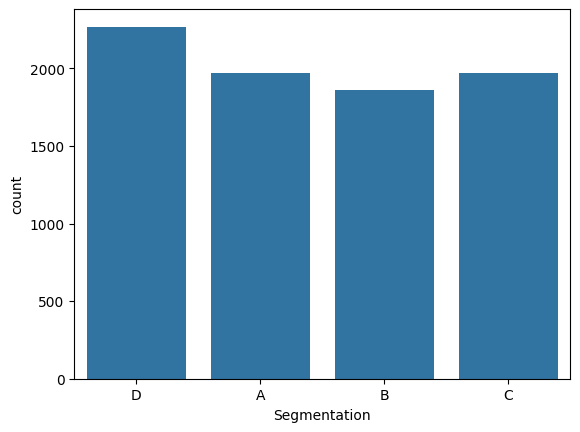

In [12]:
sns.countplot(x='Segmentation', data=df)

## Preprocessing

In [13]:
X = df.drop('Segmentation', axis=1)
y = df['Segmentation']

In [14]:
cat_columns = X.select_dtypes(include='object').columns.tolist()
num_columns = X.select_dtypes(exclude='object').columns.tolist()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

In [18]:
numerical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)


categorical_tarnsformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_columns),
        ('cat', categorical_tarnsformer, cat_columns)
    ]
)


In [19]:
cat_feature_indeces = [X_train.columns.get_loc(col) for col in cat_columns]

smotenc = SMOTENC(categorical_features=cat_feature_indeces, random_state=42)
X_train_transformed = preprocessor.fit_transform(X_train)

X_train_smotenc, y_train_smotenc = smotenc.fit_resample(X_train_transformed, y_train)

In [21]:
X_test = preprocessor.transform(X_test)

In [22]:
feature_names = preprocessor.get_feature_names_out(input_features=X.columns)
X_train_smotenc = pd.DataFrame(X_train_smotenc, columns=feature_names)
X_train_smotenc

,num__ID,num__Age,num__Work_Experience,num__Family_Size,cat__Gender_Female,cat__Gender_Male,cat__Ever_Married_No,cat__Ever_Married_Unknown,cat__Ever_Married_Yes,cat__Graduated_No,...,cat__Spending_Score_High,cat__Spending_Score_Low,cat__Var_1_Cat_1,cat__Var_1_Cat_2,cat__Var_1_Cat_3,cat__Var_1_Cat_4,cat__Var_1_Cat_5,cat__Var_1_Cat_6,cat__Var_1_Cat_7,cat__Var_1_Unknown
0,0.931296,-0.695320,1.970880,-1.231118,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.220807,1.703982,-0.456381,-0.564314,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.697318,-0.635337,-0.456381,0.769294,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.051676,0.264401,-0.759788,2.102901,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.389029,-0.935250,1.970880,-1.231118,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7251,-1.613142,1.584017,-0.456381,-0.564314,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7252,-0.790208,-0.095494,-0.456381,1.153022,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7253,0.012113,-0.155477,-0.456381,0.510460,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7254,1.295457,0.444349,-0.456381,-0.564314,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## CART

In [20]:
def tree (X_train, y_train, X_test, y_test, criterion, feature_names, class_names):
      clf = DecisionTreeClassifier(criterion=criterion)
      clf.fit(X_train, y_train)
      train_pred = clf.predict(X_train)
      test_pred = clf.predict(X_test)
      print("Train")
      print(classification_report(y_train, train_pred))
      plot_tree(clf, feature_names=feature_names, class_names=class_names)
      plt.show()
      print("Test")
      print(classification_report(y_test, test_pred))
      plt.figure(figsize=(10, 6))
      plot_tree(clf, feature_names=feature_names, class_names=class_names)
      plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Train
              precision    recall  f1-score   support

           A       1.00      1.00      1.00      1814
           B       1.00      1.00      1.00      1814
           C       1.00      1.00      1.00      1814
           D       1.00      1.00      1.00      1814

    accuracy                           1.00      7256
   macro avg       1.00      1.00      1.00      7256
weighted avg       1.00      1.00      1.00      7256



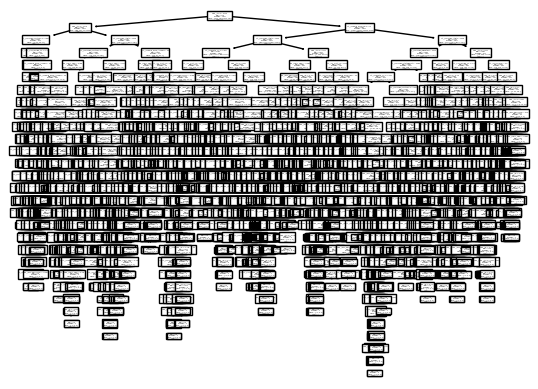

Test
              precision    recall  f1-score   support

           A       0.35      0.35      0.35       394
           B       0.37      0.39      0.38       372
           C       0.48      0.46      0.47       394
           D       0.60      0.59      0.59       454

    accuracy                           0.45      1614
   macro avg       0.45      0.45      0.45      1614
weighted avg       0.45      0.45      0.45      1614



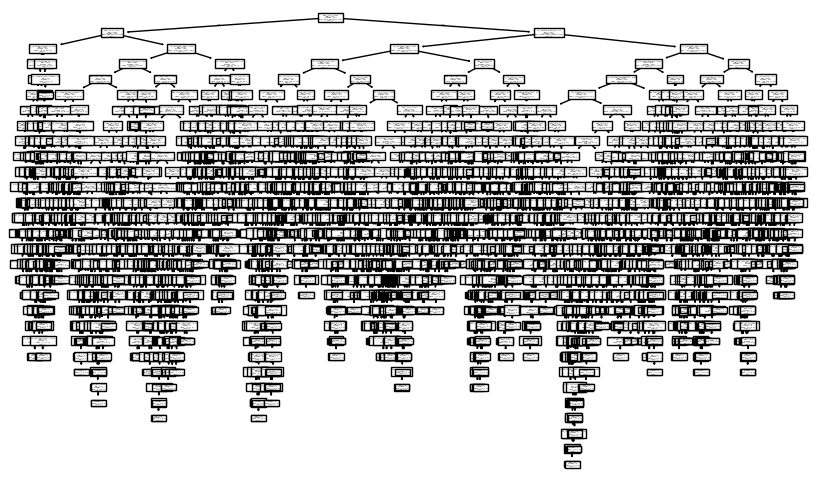

In [23]:
tree(X_train_smotenc, y_train_smotenc, X_test, y_test, 'gini',feature_names , y.unique().tolist())

Висновок: модель перенавчилась. За допомогою GridsearchCV знайдемо найкращі параметри для роботи моделі


In [26]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

clf = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid,
                           scoring='f1_macro', cv=5, n_jobs=-1)

grid_search.fit(X_train_smotenc, y_train_smotenc)


print("Best params:", grid_search.best_params_)
print("Best result:", grid_search.best_score_)


best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test score:", test_score)

Best params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
Best result: 0.501913683144818
Test score: 0.49008674101610905


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Висновок: отже, найкращі параметри для алгоритму CART {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}

Але, для best_score для цієї моделі 0.5, тому для вирішення цієї задачі потрібно натренувати інші моделі для досягнення кращого результату